Epoch: 0100 cost = 1.719997
Epoch: 0200 cost = 0.859123
Epoch: 0300 cost = 0.408179
Epoch: 0400 cost = 0.164277
Epoch: 0500 cost = 0.067775
['ich', 'mochte', 'ein', 'bier', 'P'] -> ['i', 'want', 'a', 'beer', 'E']


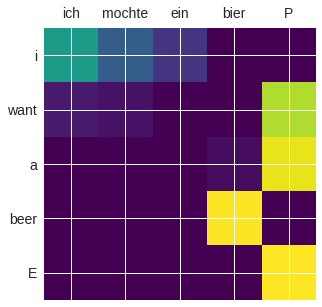


['sie', 'liebt', 'ein', 'bier', 'P'] -> ['she', 'love', 'a', 'beer', 'E']


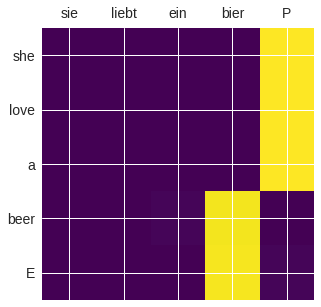


['bier', 'ist', 'eine', 'liebe', 'P'] -> ['beer', 'is', 'a', 'love', 'E']


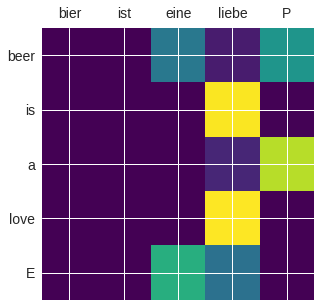

In [131]:
# code by Tae Hwan Jung(Jeff Jung) @graykode
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense
import matplotlib.pyplot as plt
import numpy as np

tf.reset_default_graph()
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
sentences = [['ich mochte ein bier P', 'S i want a beer', 'i want a beer E'], 
             ['sie liebt ein bier P', 'S she love a beer', 'she love a beer E'],
             ['bier ist eine liebe P', 'S beer is a love', 'beer is a love E']]

word_list = " ".join(sentences[0] + sentences[1] + sentences[2]).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}

# Parameter
vocab_size = len(word_dict)
n_embed = 5
n_step = 5  # maxium number of words in one sentence(=number of time steps)
n_hidden = 64
n_class = len(word_dict)  # vocab list

def make_batch(sentences):
    input_batch, output_batch, target_batch = [], [], []
    for sentence in sentences:
        input_batch.append([word_dict[n] for n in sentence[0].split()])
        output_batch.append([word_dict[n] for n in sentence[1].split()])
        target_batch.append([word_dict[n] for n in sentence[2].split()])
    
    return input_batch, output_batch, target_batch

# Model
class seq2seq_attn(object):
    def __init__(self, sess, vocab_size, n_embed, n_step, n_hidden, n_class):
        self.sess = sess
        self.vocab_size = vocab_size
        self.n_embed = n_embed
        self.n_step = n_step
        self.n_hidden = n_hidden
        self.n_class = n_class
        self._build_model()
    
    def _build_model(self):
        with tf.variable_scope('placeholder'):
            self.enc_input = tf.placeholder(tf.int32, [None, self.n_step]) # [batch_size, n_step]
            self.dec_input = tf.placeholder(tf.int32, [None, self.n_step]) # [batch_size, n_step]
            self.targets = tf.placeholder(tf.int32, [None, self.n_step]) # [batch_size, n_step]

            embedding = Embedding(self.vocab_size, self.n_embed)
            enc_input = embedding(self.enc_input) # [batch_size, n_step, n_embed]
            dec_input = embedding(self.dec_input) # [batch_size, n_step, n_embed]
        
        # Linear for attention
        attn = Dense(self.n_hidden, input_shape=(self.n_hidden,))
        out = Dense(self.n_class, input_shape=(self.n_hidden * 2,))
        
        def get_att_score(dec_output, enc_output):  # enc_output : [batch_size, n_hidden], dec_output: [1, batch_size, n_hidden]
            score = tf.expand_dims(attn(enc_output), 1)  # score : [batch_size, 1, n_hidden]
            dec_output = tf.transpose(dec_output, [1, 2, 0])  # dec_output : [batch_size, n_hidden, 1]
            return tf.squeeze(tf.matmul(score, dec_output), 1)  # [batch_size, 1]

        def get_att_weight(dec_output, enc_outputs): # dec_output: [1, batch_size, n_hidden]
            attn_scores = []
            enc_outputs = tf.transpose(enc_outputs, [1, 0, 2])  # enc_outputs : [n_step, batch_size, n_hidden]
            for i in range(self.n_step):
                attn_scores.append(get_att_score(dec_output, enc_outputs[i])) # enc_outputs[i] : [batch_size, n_hidden]
            # Normalize scores to weights in range 0 to 1
            attn_values = tf.concat(attn_scores, -1)
            return tf.reshape(tf.nn.softmax(attn_values), [-1, 1, self.n_step])  # [batch_size, 1, n_step]

                
        model = []
        Attention = []
        with tf.variable_scope('encode'):
            enc_cell = tf.nn.rnn_cell.BasicLSTMCell(self.n_hidden)
            enc_cell = tf.nn.rnn_cell.DropoutWrapper(enc_cell, output_keep_prob=0.5)
            enc_outputs, enc_hidden = tf.nn.dynamic_rnn(enc_cell, enc_input, dtype=tf.float32) # enc_outputs: [batch_size, n_step, n_hidden], enc_hidden: [batch_size, n_hidden]

        with tf.variable_scope('decode'):
            dec_cell = tf.nn.rnn_cell.BasicLSTMCell(self.n_hidden)
            dec_cell = tf.nn.rnn_cell.DropoutWrapper(dec_cell, output_keep_prob=0.5)

            inputs = tf.transpose(dec_input, [1, 0, 2]) # inputs: [n_step, batch_size, n_embed]
            hidden = enc_hidden # hidden: [batch_size, n_hidden]
            
            for i in range(self.n_step):
                # time_major True mean inputs shape: [max_time, batch_size, ...]
                dec_output, hidden = tf.nn.dynamic_rnn(dec_cell, tf.expand_dims(inputs[i], 0), # tf.expand_dims(inputs[i], 0): [1, batch_size, n_embed]
                                                       initial_state=hidden, dtype=tf.float32, time_major=True) # dec_output: [1, batch_size, n_hidden]

                attn_weights = get_att_weight(dec_output, enc_outputs)  # attn_weights : [batch_size, 1, n_step]
                Attention.append(tf.squeeze(attn_weights)) # [batch_size, n_step]
                context = tf.matmul(attn_weights, enc_outputs) # enc_outputs: [batch_size, n_step, n_hidden], # context: [batch_size, 1, n_hidden]
                dec_output = tf.squeeze(dec_output, 0)  # [batch_size, n_hidden]
                context = tf.squeeze(context, 1)  # [batch_size, n_hidden]
                model.append(out(tf.concat((dec_output, context), 1)))  # [n_step, batch_size, n_class]
        
        self.trained_attn = tf.stack([Attention[i] for i in range(self.n_step)], 0) # [n_step, batch_size, n_step]
        logits = tf.transpose(model, [1, 0, 2])  # logits : [batch_size, n_step, n_class]
        self.cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=self.targets))
        self.optimizer = tf.train.AdamOptimizer(0.001).minimize(self.cost)

        self.prediction = tf.argmax(logits, 2)

        sess.run(tf.global_variables_initializer())
    
    def train(self, enc_input, dec_input, targets):
        return self.sess.run([self.cost, self.optimizer], feed_dict={self.enc_input: enc_input, self.dec_input: dec_input, self.targets: targets})
     
    def predict(self, enc_input, dec_input):
        return self.sess.run(self.prediction, feed_dict={self.enc_input: enc_input, self.dec_input: dec_input})
      
    def get_attn(self, enc_input, dec_input):
        return self.sess.run(self.trained_attn, feed_dict={self.enc_input: enc_input, self.dec_input: dec_input})
        

# Training and Test
with tf.Session() as sess:
    model = seq2seq_attn(sess, vocab_size, n_embed, n_step, n_hidden, n_class)
    input_batch, output_batch, target_batch = make_batch(sentences)
    for epoch in range(500):
        loss, _ = model.train(input_batch, output_batch, target_batch)

        if (epoch + 1) % 100 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
    
    # Show Attention
    for sentence in sentences:
        input_batch, output_batch, _ = make_batch([sentence])
        predict_batch = [[word_dict[n] for n in 'P P P P P'.split()]]
        
        result = model.predict(input_batch, predict_batch)
        print(sentence[0].split(), '->', [number_dict[n] for n in result[0]])
        
        attention = model.get_attn(input_batch, output_batch)
        
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(1, 1, 1)
        ax.matshow(attention, cmap='viridis')
        ax.set_xticklabels([''] + sentence[0].split(), fontdict={'fontsize': 14})
        ax.set_yticklabels([''] + sentence[2].split(), fontdict={'fontsize': 14})
        plt.show()
        print()